In [75]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import keras
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **안지훈 마운트 설정(로컬 환경에 따라서 변경하세요)**

In [3]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive/', force_remount=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [4]:
from google.colab import drive
drive.mount('/content/drive')
import os
from pathlib import Path

# folder 변수에 구글드라이브에 프로젝트를 저장한 디렉토리를 입력하세요!
# My Drive 밑에 저장했다면 그대로 두시면 됩니다.
folder = ""
project_dir = "HAI 2.0"

base_path = Path("/content/drive/My Drive/Colab Notebooks/data")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
현재 디렉토리 위치: /content/drive/My Drive/Colab Notebooks/data/HAI 2.0


## **데이터 불러오기 및 normalization**

In [5]:
# 환경별로 상이 할 수 있습니다. 디렉토리 주소를 잘 참조하세요

from pathlib import Path

current_path = Path().absolute()
training_data_path = current_path / "training"
validation_data_path=current_path/ "validation"
test_data_path=current_path/"testing"

TRAIN_DATASET = sorted([x for x in Path(training_data_path).glob("*.csv")])
TEST_DATASET = sorted([x for x in Path(test_data_path).glob("*.csv")])
VALIDATION_DATASET = sorted([x for x in Path(validation_data_path).glob("*.csv")])

def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
VALIDATION_DF_RAW=dataframe_from_csvs(VALIDATION_DATASET)

In [25]:


columns= TRAIN_DF_RAW.columns.drop("time")
train_min = TRAIN_DF_RAW[columns].min()
train_max = TRAIN_DF_RAW[columns].max()
def normalize(df):
    ndf = df.copy()
    
    for c in df.columns:
        if train_min[c] == train_max[c]:
            ndf[c] = df[c] - train_min[c]
        else:
            ndf[c] = (df[c] - train_min[c]) / (train_max[c] - train_min[c])
    return ndf

def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

#train data set normalization
train = normalize(TRAIN_DF_RAW[columns]).ewm(alpha=0.9).mean() #ewm 이동평균 적용
boundary_check(train)

## validation data set normalization
columns_val=VALIDATION_DF_RAW.columns.drop(["time","attack"])
validation=normalize(VALIDATION_DF_RAW[columns_val]).ewm(alpha=0.9).mean() #ewm 이동평균 적용

## **Train data 파악하기**

In [26]:
train_notime=train.copy()

train_all=train.copy()
train_all["time"]=TRAIN_DF_RAW["time"]


Train 데이터는 두가지로 나뉩니다.
1. Train_all
->time column이 모두 있는 완전한 train 데이터 셋 변수입니다.

2. validation_notime
->time column은 존재하지 않습니다. 통계적 처리를 위한 데이터 셋입니다.


In [27]:
display(train_all.describe())

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
count,921603.000000,921603.0,921603.0,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,9.216030e+05,921603.000000,921603.000000,921603.000000,921603.000000,921603.0,921603.000000,921603.000000,9.216030e+05,921603.0,921603.0,921603.000000,921603.0,921603.0,9.216030e+05,9.216030e+05,921603.0,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,9.216030e+05,921603.0,921603.0,921603.0,921603.000000,921603.0,921603.000000,921603.000000,921603.0,921603.000000,9.216030e+05,921603.0,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,9.216030e+05,921603.0,921603.0,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,9.216030e+05,921603.0,921603.000000,921603.0,921603.000000,921603.0,921603.0,921603.0,921603.000000,921603.0,921603.000000,921603.000000,9.216030e+05,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000
mean,0.465165,0.0,0.0,0.449502,0.354876,0.270435,0.441053,0.477264,3.322286e-01,0.418924,0.509883,0.502522,0.575737,0.0,0.693048,0.430722,2.153383e-01,0.0,0.0,0.369736,0.0,0.0,3.915210e-01,5.658138e-01,0.0,0.655291,0.413507,0.156214,0.401785,0.282963,0.563509,3.283057e-01,0.0,0.0,0.0,0.605251,0.0,0.737377,0.417851,0.0,0.547057,1.728775e-01,0.0,0.571308,0.430411,0.540039,0.574660,0.156214,0.441822,3.968069e-01,0.0,0.0,0.581593,0.550005,0.451519,0.619043,0.145575,4.091267e-01,0.0,0.619042,0.0,0.475294,0.0,0.0,0.0,0.566801,0.0,0.883730,0.798310,6.360903e-01,0.297275,0.332980,0.382692,0.439215,0.279265,0.372062,0.378616,0.402974,0.617261
std,0.151090,0.0,0.0,0.229975,0.143793,0.407305,0.064493,0.089736,3.710612e-01,0.175625,0.014920,0.225625,0.320489,0.0,0.216861,0.197470,3.251817e-01,0.0,0.0,0.129487,0.0,0.0,3.627647e-01,2.965438e-01,0.0,0.229710,0.104889,0.363056,0.122857,0.223656,0.444198,4.267009e-02,0.0,0.0,0.0,0.421813,0.0,0.263877,0.150931,0.0,0.434130,2.953957e-01,0.0,0.178678,0.055926,0.221034,0.081746,0.363056,0.064816,3.656583e-01,0.0,0.0,0.022220,0.432727,0.231758,0.421291,0.229046,4.020953e-01,0.0,0.421293,0.0,0.064961,0.0,0.0,0.0,0.316496,0.0,0.249354,0.241383,5.475609e-02,0.450323,0.040202,0.111184,0.258277,0.352581,0.129844,0.140289,0.258098,0.134425
min,0.000313,0.0,0.0,0.000082,0.002391,0.000008,0.039994,0.043305,5.213600e-07,0.003094,0.046096,0.000258,0.000024,0.0,0.001647,0.000000,1.827165e-09,0.0,0.0,0.000476,0.0,0.0,1.903757e-165,6.809916e-11,0.0,0.001397,0.000028,0.000000,0.000199,0.000256,0.000041,9.891918e-24,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000422,0.0,0.000015,2.569959e-232,0.0,0.009139,0.000984,0.004002,0.056324,0.000000,0.040253,7.707358e-16,0.0,0.0,0.063913,0.000000,0.000231,0.000151,0.000070,0.000000e+00,0.0,0.000151,0.0,0.044162,0.0,0.0,0.0,0.000020,0.0,0.000000,0.022091,9.592557e-09,0.000000,0.000122,0.003568,0.000068,0.005556,0.000236,0.001337,0.000000,0.008301
25%,0.392891,0.0,0.0,0.199112,0.248066,0.000376,0.396409,0.416192,5.214179e-03,0.273241,0.500428,0.323586,0.260588,0.0,0.490917,0.343433,1.279707e-03,0.0,0.0,0.295536,0.0,0.0,2.296803e-03,3.255351e-01,0.0,0.416466,0.302727,0.000000,0.331030,0.100310,0.032345,3.276442e-01,0.0,0.0,0.0,0.121547,0.0,0.496236,0.315662,0.0,0.133732,1.283697e-03,0.0,0.424544,0.388420,0.339553,0.527205,0.000000,0.396088,5.132592e-03,0.0,0.0,0.579402,0.140125,0.202870,0.119062,0.047670,3.481232e-28,0.0,0.119055,0.0,0.432689,0.0,0.0,0.0,0.257115,0.0,0.950263,0.635223,6.050690e-01,0.000000,0.317836,0.268164,0.229732,0.083339,0.297831,0.286347,0.261620,0.528749
50%,0.462039,0.0,0.0,0.509538,0.349188,0.000922,0.449561,0.476819,1.362526e-01,0.419287,0.509776,0.498159,0.558278,0.0,0.79

In [28]:
display(train_notime.describe())

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
count,921603.000000,921603.0,921603.0,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,9.216030e+05,921603.000000,921603.000000,921603.000000,921603.000000,921603.0,921603.000000,921603.000000,9.216030e+05,921603.0,921603.0,921603.000000,921603.0,921603.0,9.216030e+05,9.216030e+05,921603.0,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,9.216030e+05,921603.0,921603.0,921603.0,921603.000000,921603.0,921603.000000,921603.000000,921603.0,921603.000000,9.216030e+05,921603.0,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,9.216030e+05,921603.0,921603.0,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,9.216030e+05,921603.0,921603.000000,921603.0,921603.000000,921603.0,921603.0,921603.0,921603.000000,921603.0,921603.000000,921603.000000,9.216030e+05,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000
mean,0.465165,0.0,0.0,0.449502,0.354876,0.270435,0.441053,0.477264,3.322286e-01,0.418924,0.509883,0.502522,0.575737,0.0,0.693048,0.430722,2.153383e-01,0.0,0.0,0.369736,0.0,0.0,3.915210e-01,5.658138e-01,0.0,0.655291,0.413507,0.156214,0.401785,0.282963,0.563509,3.283057e-01,0.0,0.0,0.0,0.605251,0.0,0.737377,0.417851,0.0,0.547057,1.728775e-01,0.0,0.571308,0.430411,0.540039,0.574660,0.156214,0.441822,3.968069e-01,0.0,0.0,0.581593,0.550005,0.451519,0.619043,0.145575,4.091267e-01,0.0,0.619042,0.0,0.475294,0.0,0.0,0.0,0.566801,0.0,0.883730,0.798310,6.360903e-01,0.297275,0.332980,0.382692,0.439215,0.279265,0.372062,0.378616,0.402974,0.617261
std,0.151090,0.0,0.0,0.229975,0.143793,0.407305,0.064493,0.089736,3.710612e-01,0.175625,0.014920,0.225625,0.320489,0.0,0.216861,0.197470,3.251817e-01,0.0,0.0,0.129487,0.0,0.0,3.627647e-01,2.965438e-01,0.0,0.229710,0.104889,0.363056,0.122857,0.223656,0.444198,4.267009e-02,0.0,0.0,0.0,0.421813,0.0,0.263877,0.150931,0.0,0.434130,2.953957e-01,0.0,0.178678,0.055926,0.221034,0.081746,0.363056,0.064816,3.656583e-01,0.0,0.0,0.022220,0.432727,0.231758,0.421291,0.229046,4.020953e-01,0.0,0.421293,0.0,0.064961,0.0,0.0,0.0,0.316496,0.0,0.249354,0.241383,5.475609e-02,0.450323,0.040202,0.111184,0.258277,0.352581,0.129844,0.140289,0.258098,0.134425
min,0.000313,0.0,0.0,0.000082,0.002391,0.000008,0.039994,0.043305,5.213600e-07,0.003094,0.046096,0.000258,0.000024,0.0,0.001647,0.000000,1.827165e-09,0.0,0.0,0.000476,0.0,0.0,1.903757e-165,6.809916e-11,0.0,0.001397,0.000028,0.000000,0.000199,0.000256,0.000041,9.891918e-24,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000422,0.0,0.000015,2.569959e-232,0.0,0.009139,0.000984,0.004002,0.056324,0.000000,0.040253,7.707358e-16,0.0,0.0,0.063913,0.000000,0.000231,0.000151,0.000070,0.000000e+00,0.0,0.000151,0.0,0.044162,0.0,0.0,0.0,0.000020,0.0,0.000000,0.022091,9.592557e-09,0.000000,0.000122,0.003568,0.000068,0.005556,0.000236,0.001337,0.000000,0.008301
25%,0.392891,0.0,0.0,0.199112,0.248066,0.000376,0.396409,0.416192,5.214179e-03,0.273241,0.500428,0.323586,0.260588,0.0,0.490917,0.343433,1.279707e-03,0.0,0.0,0.295536,0.0,0.0,2.296803e-03,3.255351e-01,0.0,0.416466,0.302727,0.000000,0.331030,0.100310,0.032345,3.276442e-01,0.0,0.0,0.0,0.121547,0.0,0.496236,0.315662,0.0,0.133732,1.283697e-03,0.0,0.424544,0.388420,0.339553,0.527205,0.000000,0.396088,5.132592e-03,0.0,0.0,0.579402,0.140125,0.202870,0.119062,0.047670,3.481232e-28,0.0,0.119055,0.0,0.432689,0.0,0.0,0.0,0.257115,0.0,0.950263,0.635223,6.050690e-01,0.000000,0.317836,0.268164,0.229732,0.083339,0.297831,0.286347,0.261620,0.528749
50%,0.462039,0.0,0.0,0.509538,0.349188,0.000922,0.449561,0.476819,1.362526e-01,0.419287,0.509776,0.498159,0.558278,0.0,0.79

In [30]:
train["C01"].std()

0.15108960966594007

In [31]:
#std가 0 인 컬럼 파악하기

std0list=[]
for c in train_notime.columns:
  colstd=train[c].std()
  if colstd==0.0:
    std0list.append(c)
print(std0list)

['C02', 'C03', 'C14', 'C18', 'C19', 'C21', 'C22', 'C25', 'C33', 'C34', 'C35', 'C37', 'C40', 'C43', 'C51', 'C52', 'C59', 'C61', 'C63', 'C64', 'C65', 'C67']


## **Train data 시계열 그래프 그리기 (각 컬럼별)**



In [32]:
#time colum str->datetime으로 overloading
train_all['time']=pd.to_datetime(train_all["time"])


In [33]:
#train data는 크게 3개의 시계열 덩어리로 나타나있습니다. 전체를 다 보려면 train_all을 변수로 보면 됩니다. 

firstset=train_all[train_all['time']<'2020-07-13']
secondset=train_all[(train_all['time']>'2020-07-13') & (train_all['time']<'2020-08-04')]
thirdset=train_all[train_all['time']>'2020-08-04']

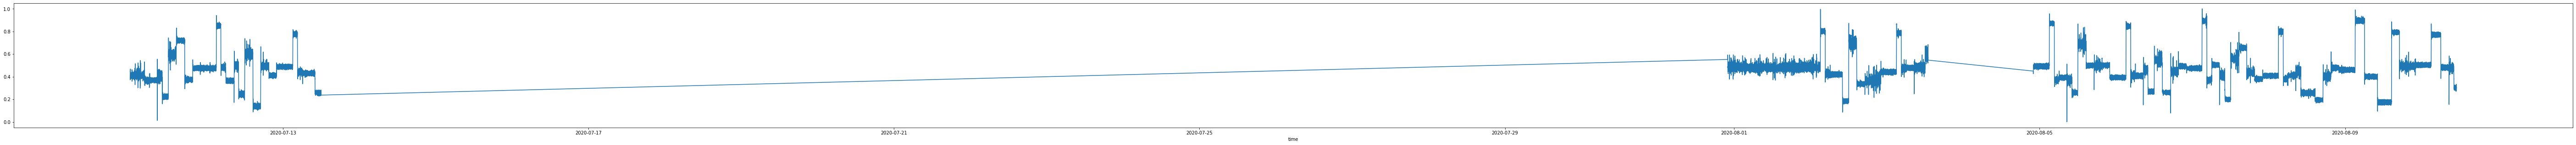

In [34]:
import datetime
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#전체 train data를보기
x1 = train_all["time"]
y1 = train_all["C01"]

#개별 덩이리를 보기

#x1 = firstset["time"]
#y1= firstset['C04']


# plot
plt.plot(x1,y1)

#아래 코드들을 추가하면 겹쳐서 볼 수 있습니다.
#plt.plot(x1,y2)
#plt.plot(x1,y3)

#plot option
plt.rcParams["figure.figsize"] = (10,5)

plt.xlabel('time')
plt.show()

## **Validation data set 파악**

In [35]:
validation_notime=validation.copy()
validation_all=validation.copy()
validation_notime["attack"]=VALIDATION_DF_RAW['attack']
validation_all[['attack','time']]=VALIDATION_DF_RAW[['attack','time']]

#time column datetime type으로 형변환(기존에는 str이여서 파악하기 힘듦)
validation_all['time']=pd.to_datetime(validation_all['time'])

Validation 데이터는 두가지로 나뉩니다.
1. validation_all
->attack,time column이 모두 있는 완전한 validation 데이터 셋 변수입니다.

2. validation_notime
->attack 컬럼만 추가되고 time column은 존재하지 않습니다.

In [36]:
validation_all.describe()

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,attack
count,43201.000000,43201.000000,43201.0,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.0,43201.000000,43201.000000,43201.000000,43201.0,43201.0,43201.000000,43201.0,43201.0,4.320100e+04,43201.000000,43201.0,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.0,43201.0,43201.0,43201.000000,43201.0,43201.000000,43201.000000,43201.0,43201.000000,43201.000000,43201.0,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,4.320100e+04,43201.0,43201.0,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,4.320100e+04,43201.0,43201.000000,43201.0,43201.000000,43201.0,43201.0,43201.0,43201.000000,43201.0,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000
mean,0.426533,0.001679,0.0,0.497970,0.458110,0.234134,0.453634,0.449229,0.328822,0.429076,0.509876,0.506590,0.671233,0.0,0.739856,0.374390,0.217993,0.0,0.0,0.367932,0.0,0.0,4.098675e-01,0.546805,0.0,0.703839,0.459849,0.413854,0.406960,0.311131,0.599239,0.326573,0.0,0.0,0.0,0.630823,0.0,0.796275,0.416856,0.0,0.560745,0.170445,0.0,0.374178,0.447100,0.427336,0.615383,0.413854,0.454439,4.153656e-01,0.0,0.0,0.581642,0.563552,0.502784,0.656844,0.152667,4.282329e-01,0.0,0.656840,0.0,0.493006,0.0,0.0,0.0,0.661806,0.0,0.989758,0.799742,0.650675,0.263001,0.331700,0.433241,0.462179,0.960016,0.370248,0.376794,0.403149,0.360161,0.014560
std,0.090840,0.056400,0.0,0.212860,0.118455,0.387177,0.115375,0.086972,0.366975,0.153434,0.015050,0.223933,0.310838,0.0,0.167838,0.065378,0.328609,0.0,0.0,0.122709,0.0,0.0,3.605197e-01,0.292646,0.0,0.184512,0.111111,0.492526,0.114989,0.230434,0.434469,0.046879,0.0,0.0,0.0,0.401306,0.0,0.200011,0.125131,0.0,0.422547,0.290529,0.0,0.173301,0.061666,0.219368,0.182223,0.492526,0.115788,3.634492e-01,0.0,0.0,0.022772,0.421746,0.215532,0.406878,0.221326,4.012240e-01,0.0,0.406882,0.0,0.062911,0.0,0.0,0.0,0.308159,0.0,0.006710,0.243338,0.053708,0.433938,0.045512,0.119509,0.274854,0.245070,0.122672,0.133839,0.203251,0.153703,0.119784
min,0.096924,0.000000,0.0,-0.074369,0.160932,0.000015,-2.108937,0.061364,0.000058,0.069914,0.394839,0.032609,-0.125903,0.0,-0.197649,0.313259,-0.000548,0.0,0.0,0.032114,0.0,0.0,2.073233e-143,0.005927,0.0,-0.167675,0.000002,0.000000,0.093019,0.000257,0.000337,-0.257205,0.0,0.0,0.0,0.000000,0.0,0.410998,0.112932,0.0,0.000084,-0.000770,0.0,-0.016844,0.006700,-0.159534,-3.415329,0.000000,-2.120585,8.554243e-07,0.0,0.0,0.385906,0.000000,-0.080200,0.001239,0.001129,0.000000e+00,0.0,0.001239,0.0,0.223788,0.0,0.0,0.0,-0.118361,0.0,0.979634,0.100994,0.000045,0.000000,-0.243918,-0.080969,0.013515,0.838877,0.035659,0.037881,0.179704,0.007835,0.000000
25%,0.379900,0.000000,0.0,0.323752,0.377908,0.000230,0.429211,0.390646,0.007529,0.289704,0.500298,0.326062,0.344354,0.0,0.677231,0.328929,0.000914,0.0,0.0,0.296304,0.0,0.0,6.979457e-03,0.291563,0.0,0.626612,0.394755,0.000000,0.339968,0.117571,0.066010,0.329111,0.0,0.0,0.0,0.220836,0.0,0.720857,0.314576,0.0,0.142529,0.001027,0.0,0.239175,0.421829,0.223382,0.574454,0.000000,0.430581,9.419257e-03,0.0,0.0,0.579401,0.149163,0.322353,0.242675,0.048082,3.482743e-14,0.0,0.242429,0.0,0.451180,0.0,0.0,0.0,0.339506,0.0,0.987947,0.666577,0.632003,0.000000,0.317453,0.362869,0.242687,0.888881,0.298620,0.284868,0.179704,0.260533,0.000000
50%,0.398031,0.000000,0.0,0.513695,0.455524,0.000615,0.458637,0.449417,0.133296,0.432514,0.509839,0.503923,0.779918,0.0,0.783638,0.328929,0.008403,0.0,0.0,0.367504,0.0,0.0,4.146569e-01,0.576891

## **Validationset 중 std가 0인 것들**

In [37]:
std0list_val=[]
for c in validation.columns:
  colstd=train[c].std()
  if colstd==0.0:
    std0list_val.append(c)
print(std0list_val)

['C02', 'C03', 'C14', 'C18', 'C19', 'C21', 'C22', 'C25', 'C33', 'C34', 'C35', 'C37', 'C40', 'C43', 'C51', 'C52', 'C59', 'C61', 'C63', 'C64', 'C65', 'C67']


In [59]:
#함수 형식으로 해서 볼 수도 있다.

def find_cols(df):
    col = dict()
    for c in df.columns:
        if c == 'time' or c == 'attack':
            continue
            
        min_val = df[c].min()
        max_val = df[c].max()
        if min_val == max_val:
            col[c] = min_val
    return pd.DataFrame([col])

display(find_cols(validation_all))
display(find_cols(validation_all[validation_all.attack == 0]))
display(find_cols(validation_all[validation_all.attack == 1]))

,C03,C14,C18,C19,C21,C22,C25,C33,C34,C35,C37,C40,C43,C51,C52,C59,C61,C63,C64,C65,C67
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,C03,C14,C18,C19,C21,C22,C25,C33,C34,C35,C37,C40,C43,C51,C52,C59,C61,C63,C64,C65,C67
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,C03,C14,C18,C19,C21,C22,C25,C28,C33,C34,C35,C37,C40,C43,C48,C51,C52,C59,C61,C63,C64,C65,C67,C71
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **Validation data set 그래프 그리기**

Validation 전체 컬럼 한 그래프에 나타내기

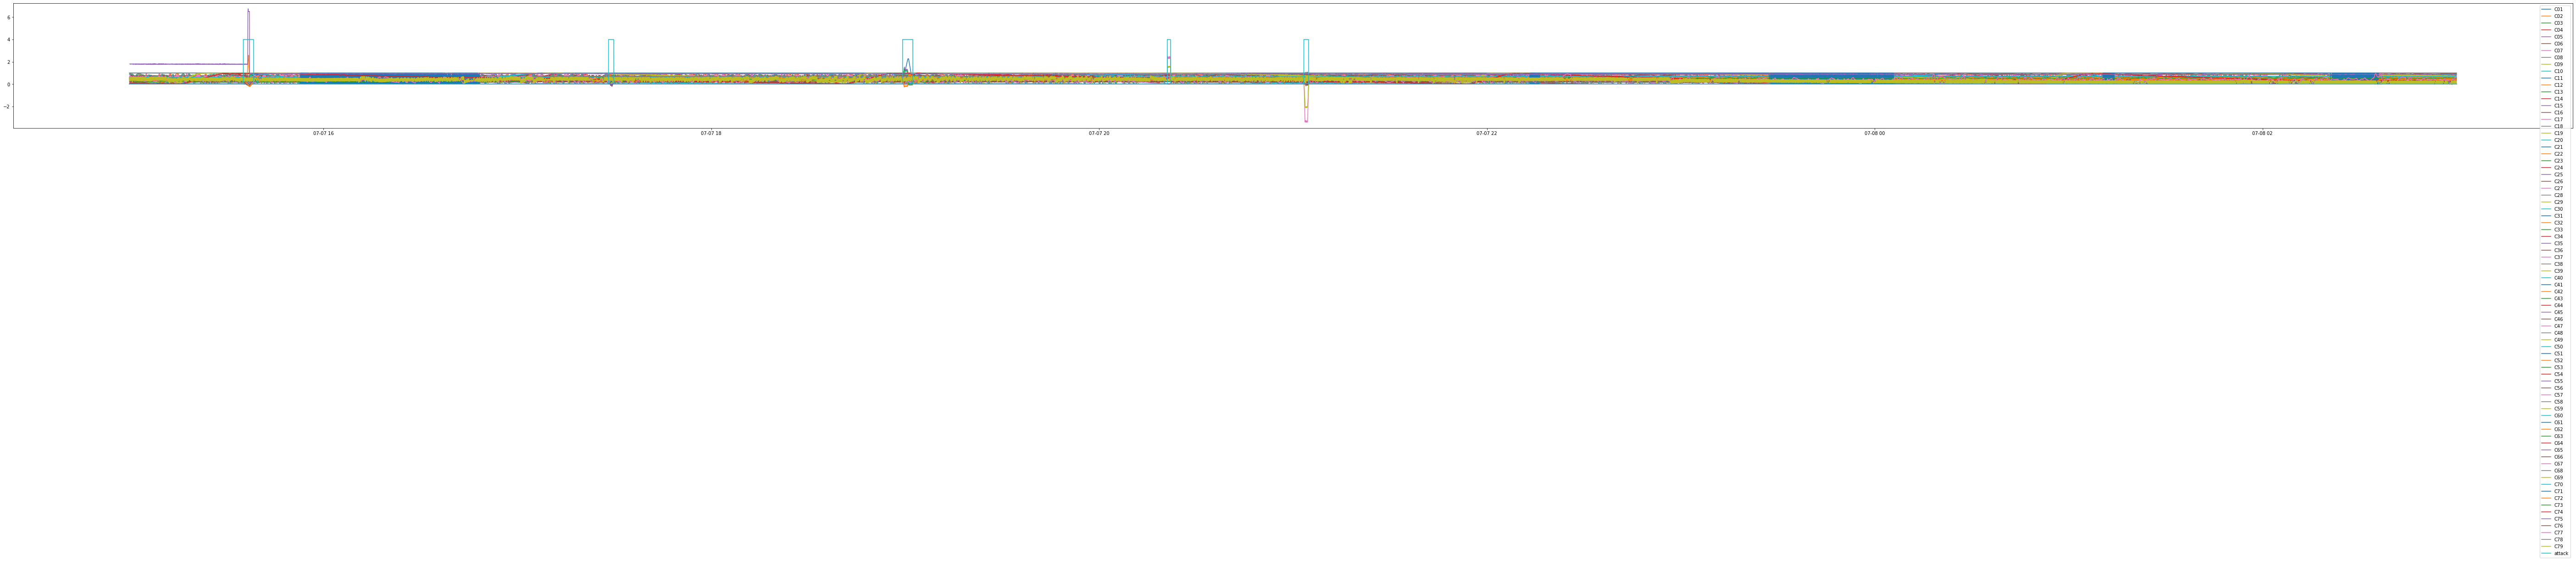

In [41]:
#x축 시간으로 고정
x1 = validation_all["time"]

#범례 설정
legend_list=[]

#Validation 모든 컬럼들 한 그래프에 나타내는 for 문
for k in list(validation_notime.columns):
   if k =='attack':
     continue
   y=k
   plt.plot(x1,validation_notime[k])
   legend_list.append(k)


#attack부분 *4해서 표기하기 (하늘색 선이 attack입니다.)
valset_attack=validation_all.copy()
valset_attack['attack']=valset_attack['attack']*4

#attack 표시
plt.plot(x1,valset_attack['attack'])
legend_list.append('attack')

#plot 설정
plt.rcParams["figure.figsize"] = (30,5)
plt.legend(legend_list)
plt.show()


validation 개별 컬럼별로 그래프에 나타내기

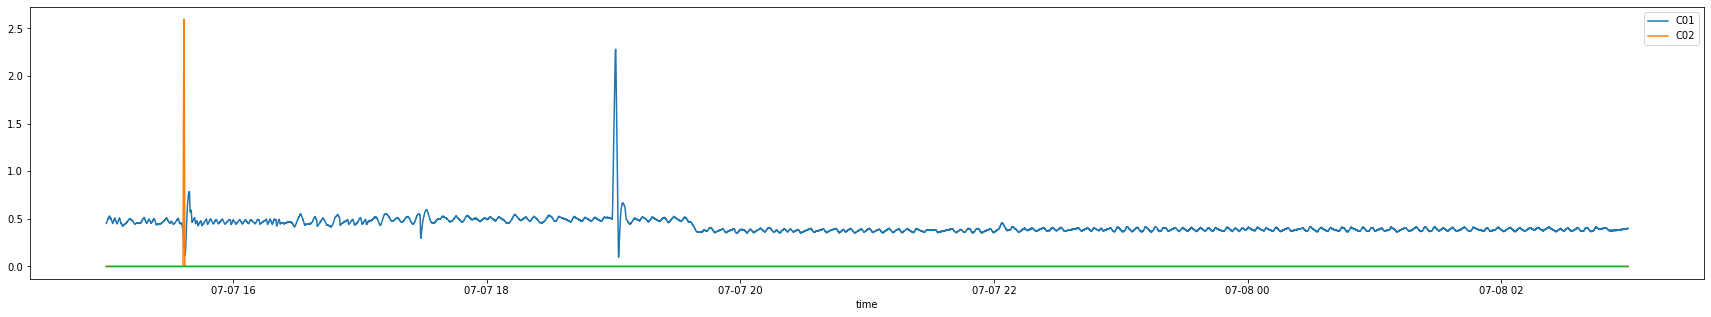

In [39]:
#x축 시간으로 고정
x1 = validation_all["time"]


#y축은 normalized이미 되었습니다.
# 확인하고 싶은 컬럼 y#=valset[{컬럼명}] 형식으로 추가하세요
y1 = validation_all["C01"]
y2 = validation_all["C02"]
y3= validation_all['C03']
#y4= valset[컬럼명]

# plot
plt.plot(x1,y1)
plt.plot(x1,y2)
plt.plot(x1,y3)
#plt.plot(x1,y#) 이 부분에 원하는 컬럼 넣으면 됩니다.

#plt 설정
plt.rcParams["figure.figsize"] = (100,5)
plt.legend(['C01','C02'])
plt.xlabel('time')
plt.show()

attack 부분만 표시한 것

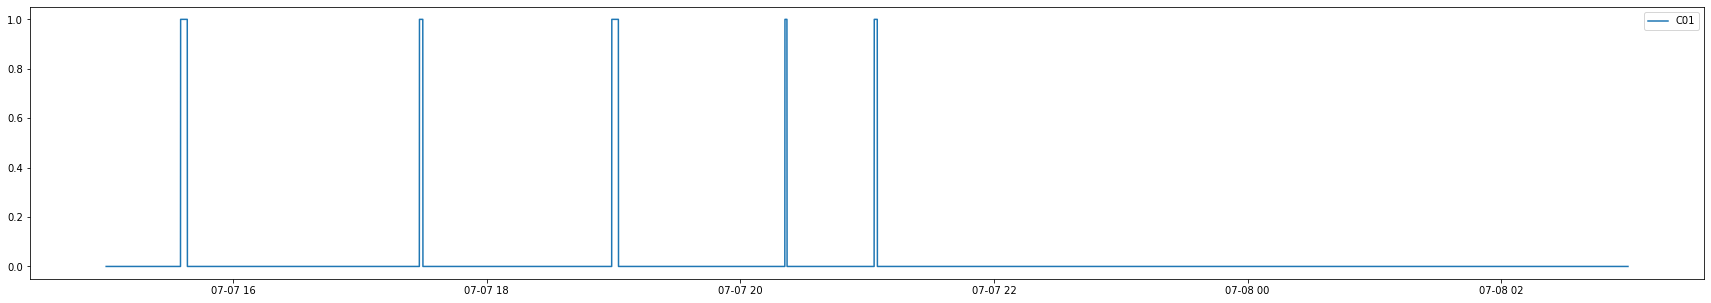

In [54]:

plt.plot(validation_all['time'],validation_all['attack'])

plt.rcParams["figure.figsize"] = (100,5)
plt.legend(legend_list)
plt.show()

## Validation data중 attack이 있었던 경우만 따로 파악

In [55]:
#attack이 있었던 시간대만 추출하기
display(validation_all[validation_all.attack==1])

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,...,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,attack,time
2111,0.447041,0.0,0.0,0.157850,0.592372,0.000085,0.490915,0.292932,0.095984,0.504168,0.515107,0.744762,0.205727,0.0,0.411976,0.435877,0.000183,0.0,0.0,0.447191,0.0,0.0,0.786958,0.154581,0.0,0.345873,0.271701,0.0,0.478956,0.651346,0.979697,0.390776,0.0,0.0,0.0,0.758470,0.0,0.410998,0.523727,0.0,...,0.026303,0.0,0.606654,0.376068,0.262470,0.647712,0.0,0.495673,0.801244,0.0,0.0,0.585389,0.755836,0.179853,0.993642,0.051136,0.858339,0.0,0.991255,0.0,0.517762,0.0,0.0,0.0,0.204044,0.0,0.997506,0.979798,0.564950,0.0,0.347400,0.230718,0.945946,1.777762,0.454987,0.480583,0.52712,0.460792,1,2020-07-07 15:35:11
2112,0.446236,0.0,0.0,0.157828,0.599581,0.000216,0.448805,0.422977,0.091369,0.635528,0.496739,0.750779,0.205644,0.0,0.413139,0.435877,0.000183,0.0,0.0,0.455326,0.0,0.0,0.791258,0.153311,0.0,0.343056,0.272647,0.0,0.482506,0.650889,0.985878,0.339799,0.0,0.0,0.0,0.758280,0.0,0.410998,0.525931,0.0,...,0.025275,0.0,0.499792,0.381518,0.465223,0.657953,0.0,0.448301,0.804590,0.0,0.0,0.583803,0.756550,0.179868,0.994416,0.051171,0.859478,0.0,0.993642,0.0,0.500351,0.0,0.0,0.0,0.205705,0.0,0.997506,0.979798,0.595076,0.0,0.333844,0.233514,0.945946,1.777762,0.457646,0.486172,0.52712,0.353036,1,2020-07-07 15:35:12
2113,0.446600,0.0,0.0,0.157826,0.540647,0.000160,0.428029,0.481938,0.086741,0.638765,0.524671,0.746473,0.205728,0.0,0.407701,0.435877,0.000018,0.0,0.0,0.450035,0.0,0.0,0.794130,0.152694,0.0,0.345130,0.272741,0.0,0.483855,0.653356,0.986411,0.334701,0.0,0.0,0.0,0.758035,0.0,0.410998,0.526768,0.0,...,0.020782,0.0,0.301373,0.378199,0.721277,0.556704,0.0,0.432172,0.808004,0.0,0.0,0.585230,0.753713,0.182582,0.989542,0.051174,0.860611,0.0,0.994416,0.0,0.420288,0.0,0.0,0.0,0.205349,0.0,0.997506,0.979798,0.599505,0.0,0.330684,0.236663,0.952028,1.777762,0.456439,0.480637,0.52712,0.263397,1,2020-07-07 15:35:13
2114,0.447081,0.0,0.0,0.157826,0.469821,0.000154,0.420432,0.462598,0.082112,0.538556,0.522386,0.748042,0.205737,0.0,0.404381,0.435877,0.000166,0.0,0.0,0.457247,0.0,0.0,0.796859,0.152142,0.0,0.346515,0.270564,0.0,0.484609,0.651090,0.983205,0.334191,0.0,0.0,0.0,0.757777,0.0,0.410998,0.527238,0.0,...,0.018715,0.0,0.195467,0.379974,0.780476,0.549989,0.0,0.419167,0.810655,0.0,0.0,0.583047,0.752135,0.184631,0.992757,0.052122,0.861821,0.0,0.989542,0.0,0.490015,0.0,0.0,0.0,0.203785,0.0,0.997506,0.979798,0.596832,0.0,0.330368,0.236683,0.946554,1.777762,0.461656,0.479299,0.52712,0.258956,1,2020-07-07 15:35:14
2115,0.448018,0.0,0.0,0.157826,0.395223,0.000154,0.438607,0.439146,0.078003,0.393544,0.518393,0.745593,0.205645,0.0,0.406825,0.435877,0.000181,0.0,0.0,0.454129,0.0,0.0,0.799573,0.150677,0.0,0.347832,0.268887,0.0,0.489408,0.650863,0.982799,0.334140,0.0,0.0,0.0,0.757494,0.0,0.410998,0.530217,0.0,...,0.015042,0.0,0.187570,0.379449,0.693143,0.593635,0.0,0.440651,0.813230,0.0,0.0,0.585155,0.751540,0.184415,0.993034,0.051584,0.862647,0.0,0.992757,0.0,0.470971,0.0,0.0,0.0,0.202036,0.0,0.997506,0.979798,0.598264,0.0,0.329889,0.236874,0.946007,1.777762,0.460644,0.480734,0.52712,0.315762,1,2020-07-07 15:35:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21885,0.380040,0.0,0.0,0.513692,0.404658,0.000230,-0.619749,0.528978,0.002951,0.285299,0.505861,0.447160,0.863544,0.0,0.781502,0.313259,0.004205,0.0,0.0,0.302194,0.0,0.0,0.623284,0.799573,0.0,0.743647,0.491493,0.0,0.324767,0.106398,0.990522,0.334141,0.0,0.0,0.0,1.000000,0.0,0.846144,0.391111,0.0,...,0.00102

In [ ]:
np.array(attack_occur['time'])
#attack이 있던 시간
#1: 2020-07-07T15:35:11.000000000 ~ 2020-07-07T15:38:22.000000000
#2: 2020-07-07T17:28:11.000000000 ~ 2020-07-07T17:29:48.000000000
#3: 2020-07-07T18:59:11.000000000 ~ 2020-07-07T19:02:20.000000000
#4: 2020-07-07T20:21:06.000000000 ~ 2020-07-07T20:22:05.000000000
#5: 2020-07-07T21:03:21.000000000 ~ 2020-07-07T21:04:48.000000000

In [44]:
#attack받은 시간대 별 분절
attack1=attack_occur[(attack_occur['time']>='2020-07-07T15:35:11') & (attack_occur['time']<='2020-07-07T15:38:22')] 
attack2=attack_occur[(attack_occur['time']>='2020-07-07T17:28:11') & (attack_occur['time']<='2020-07-07T17:29:48')] 
attack3=attack_occur[(attack_occur['time']>='2020-07-07T18:59:11') & (attack_occur['time']<='2020-07-07T19:02:20')] 
attack4=attack_occur[(attack_occur['time']>='2020-07-07T20:21:06') & (attack_occur['time']<='2020-07-07T20:22:05')] 
attack5=attack_occur[(attack_occur['time']>='2020-07-07T21:03:21') & (attack_occur['time']<='2020-07-07T21:04:48')] 

In [45]:
#attack 기간중 std가 0이 아닌 컬럼들 리스트화
attack1_std0_list=(attack1.std()==0)[(attack1.std()==0).values==False].index
attack2_std0_list=(attack2.std()==0)[(attack2.std()==0).values==False].index
attack3_std0_list=(attack3.std()==0)[(attack3.std()==0).values==False].index
attack4_std0_list=(attack4.std()==0)[(attack4.std()==0).values==False].index


Index(['C01', 'C02', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11',
       'C12', 'C13', 'C15', 'C16', 'C17', 'C20', 'C23', 'C24', 'C26', 'C27',
       'C29', 'C30', 'C31', 'C32', 'C36', 'C38', 'C39', 'C41', 'C42', 'C44',
       'C45', 'C46', 'C47', 'C49', 'C50', 'C53', 'C54', 'C55', 'C56', 'C57',
       'C58', 'C60', 'C62', 'C66', 'C68', 'C69', 'C70', 'C72', 'C73', 'C74',
       'C75', 'C76', 'C77', 'C78', 'C79'],
      dtype='object')

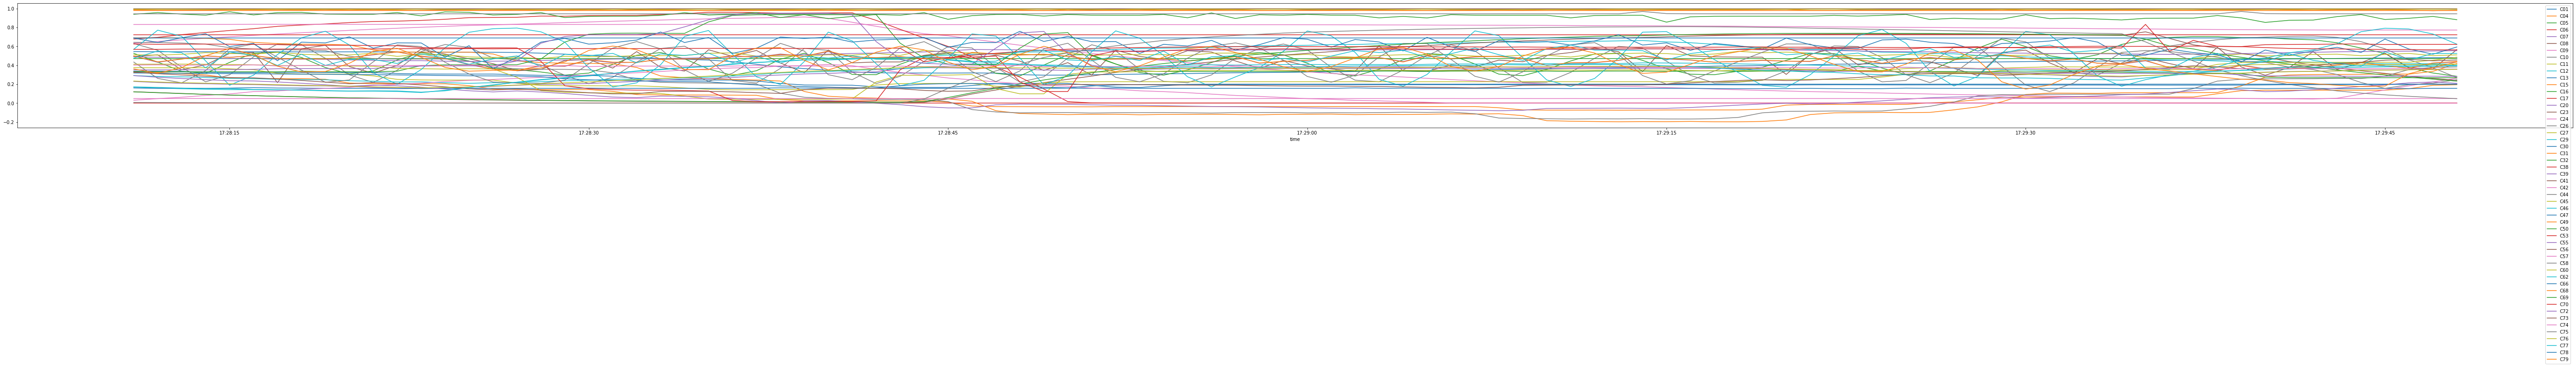

In [56]:

x1=attack2['time']  #attack1['time'],attack2['time'], attack3['time'], attack4['time'] 중 확인하고 싶은 걸로 바꾸시면 됩니다.

#범례 설정
attack2_legend=[]
for k in attack2_std0_list:
  plt.plot(x1,attack2[k]) #attack1['time'],attack2['time'], attack3['time'], attack4['time'] 중 확인하고 싶은 걸로 바꾸시면 됩니다.
  attack2_legend.append(k)

#범례 설정
plt.legend(attack2_legend)
plt.xlabel('time')
plt.show()


특이 값을 보이는 컬럼 파악하기

In [72]:
def checkstat(df):
  df_real=df[df.columns.drop('time')]
  mean=(df_real.mean()>1)[(df_real.mean()>1).values==True].index #mean 값 기준은 여기서 변경하세여
  min=(df_real.min()<0)[(df_real.min()<0).values==True].index#min 값 기준은 여기서 변경하세요
  max=(df_real.max()>1)[(df_real.max()>1).values==True].index#max값 기준은 여기서 변경하세요

  print("high mean columns:", mean)
  print('low min columns:', min)
  print('high max columns:', max)

#이렇게 하시면 됩니다.
checkstat(attack2) #attack1,2,3,4 넣기

high mean columns: Index([], dtype='object')
low min columns: Index(['C04', 'C15', 'C26', 'C55'], dtype='object')
high max columns: Index([], dtype='object')


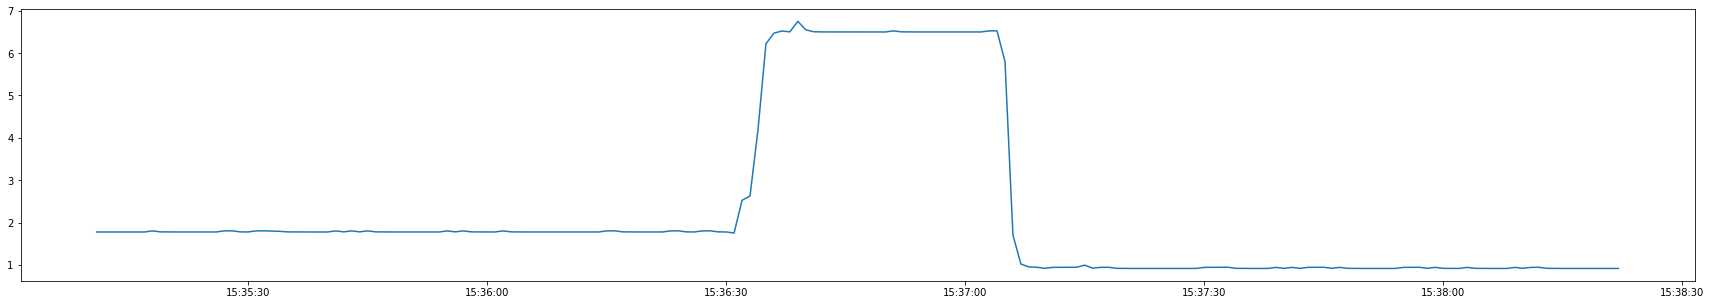

In [47]:
#1개 컬럼 확인하기
x1=attack1['time']. #attack1,2,3,4 확인하고 싶은것 확인하기.
y1=attack1['C75'] #컬럼명은 여기서 바꾸시면 됩니다.
plt.plot(x1,y1)

선영님이 제기하신 의문

왜 굳이 이전 state 값을 가지고 다음의 정상 state를 예측한 다음 차이가 많이 나면 공격 상태로 보게 했을까?
: 클러스터링이 어려운 건가? 다시 말해, 정상 state가 일정 범주 내에 있고, clustering 하는 식으로는 불가능한 걸까?

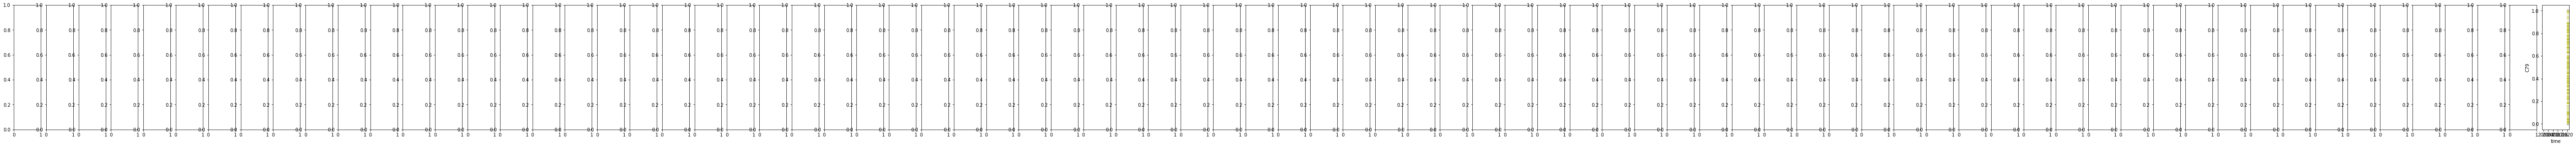

In [81]:
# training set
fig, axs = plt.subplots(ncols=79)

for col in train_notime.columns:
    sns.scatterplot(data = train_all, x = 'time', y = col)

plt.show()

In [ ]:
fig, axs = plt.subplots(ncols=78)
for idx, col in enumerate(validation_notime):
    sns.scatterplot(data = validation_all, x = validation_all.time, y = col, hue = validation_all.attack, ax = axs[idx])